In [81]:
# Define Sentinel-2 Dataset

import h5py
import os
import glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class sentinel(Dataset):
    
    @staticmethod 
    def open_h5(path,rgb = False):
        with h5py.File(path, 'r') as h5:
            
            labl = torch.from_numpy(h5['train_id'][:,:].astype('long'))
            
            if rgb:
                img = np.moveaxis(h5['raw'][0:3,:,:],0,-1)
            else:
                img = np.moveaxis(h5['raw'][:,:,:],0,-1)
                
            return(img,labl)
    
    def __init__(self,img_transform=None,label_transform=None,padding=None,root_dir=None, 
                 ext='*.nc',rgb=False):
        self.root_dir = root_dir # Dataset dir
        self.patch_files = glob.glob(os.path.join(self.root_dir, ext))
        self.padding = padding
        self.img_transform = img_transform
        self.label_transform=label_transform 
        self.rgb = rgb
        
    def __len__(self):
        return len(self.patch_files)

    def __getitem__(self, idx):
        x,y = self.open_h5(self.patch_files[idx], self.rgb)
        
        if self.img_transform:
            x = self.img_transform(x)
            
        if self.label_transform:
           y = self.label_transform(y)
            
        if self.padding: # IF True
            pad = nn.ZeroPad2d(self.padding) # Pads the input tensor boundaries with zero.
            x = pad(x)
            y= pad(y)
        
        return (x,y)

In [82]:
# Create train dataset
train_set= sentinel(root_dir="path_to_dir")

# Pass in the train dataset into DataLoader to create an iterable over the train dataset
training_loader = DataLoader(train_set)

# Create an object which can be iterated one element at a time
trainiter = iter(training_loader)

In [83]:
# Count all classes/labels in the enitre dataset and per sample
# Compute weights wrt the entire dataset and per sample

n_classes_dataset = torch.zeros(27,dtype=torch.int)
class_weights_dataset = torch.zeros(27,dtype=torch.float)

n_classes_sample = torch.zeros(len(trainiter),27,dtype=torch.int)
class_weights_sample = torch.zeros(len(trainiter),27,dtype=torch.float)

# Count classes/labels in entire dataset. Save total count and count per sample
# i = samples/patches in dataset, j=examples/instances/rows in sample/patch
for i, (_, labels) in enumerate(trainiter):
    classes,count = labels.unique(return_counts=True)
    for j in classes:
        idx = (classes==j).nonzero().item()
        classCount = count[idx].item()
        n_classes_dataset[j] += classCount
        n_classes_sample[i][j] = classCount

############### Weights wrt sample

# Set class weight = 0 for label = 0
# Inf control. Init torch.zero not actually "zero"
for i in range(len(n_classes_sample)):
    for j in range(len(n_classes_sample[i])):
        if j == 0:
            class_weights_sample[i][j] = 0
        elif n_classes_sample[i][j].item() != 0:
            class_weights_sample[i][j] = torch.max(n_classes_sample[i])/n_classes_sample[i][j]
            
################ Weights wrt dataset

#class_weights_dataset=n_classes_dataset/n_classes_dataset.sum()

# Set class weight = 0 for label = 0
#class_weights_dataset[0] = 0

# Inf control. Init torch.zero not actually "zero"
for i, count in enumerate(n_classes_dataset):
    if i == 0:
        class_weights_dataset[i] = 0
    elif count.item() != 0:
        class_weights_dataset[i] = torch.max(n_classes_dataset)/n_classes_dataset[i]
        
################

print("Counted class occurances wrt the entire dataset before oversampling:")
print(n_classes_dataset)
print("Class weights wrt the entire dataset:")
print(class_weights_dataset)

Counted class occurances wrt the entire dataset before oversampling:
tensor([  564463,   127936,   644403,  1708514,  4420600,  4589567,  1688988,
         4512423, 10245661,   650000,    69655,   457742,   742778,   191937,
          185201,  2363433,  2209367, 26341598,     3575, 22640340,        0,
               0, 74517458,  1444607,    12700,  1547069, 11003953],
       dtype=torch.int32)
Class weights wrt the entire dataset:
tensor([0.0000e+00, 5.8246e+02, 1.1564e+02, 4.3615e+01, 1.6857e+01, 1.6236e+01,
        4.4120e+01, 1.6514e+01, 7.2731e+00, 1.1464e+02, 1.0698e+03, 1.6279e+02,
        1.0032e+02, 3.8824e+02, 4.0236e+02, 3.1529e+01, 3.3728e+01, 2.8289e+00,
        2.0844e+04, 3.2914e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 5.1583e+01,
        5.8675e+03, 4.8167e+01, 6.7719e+00])


Class count for the entire dataset:

Label 0: 564,463 <<>> <<>> <<>> Unclassified
Label 1: 127,936 <<>> <<>> <<>> Continuous Urban Fabric
Label 2: 644,403 <<>> <<>> <<>> Discontinuous Dense Urban Fabric
Label 3: 1,708,514 <<>> <<>> <<>> Discontinuous Medium Density Urban Fabric
Label 4: 4,420,600 <<>> <<>> <<>> Discontinuous Low Density Urban Fabric
Label 5: 4,589,567 <<>> <<>> <<>> Discontinuous Very Low Density Urban Fabric
Label 6: 1,688,988 <<>> <<>> <<>> Isolated Structures
Label 7: 4,512,423 <<>> <<>> <<>> Industrial, commercial, public, military and private units
Label 8: 10,245,661 <<>> <<>> <<>> Roads
Label 9: 650,000 <<>> <<>> <<>> Railways and associated land
Label 10: 69,655 <<>> <<>> <<>> Port areas
Label 11: 457,742 <<>> <<>> <<>> Airports
Label 12: 742,778 <<>> <<>> <<>> Mineral extraction and dump sites
Label 13: 191,937 <<>> <<>> <<>> Construction sites
Label 14: 185,201 <<>> <<>> <<>> Land without current use
Label 15: 2,363,433 <<>> <<>> <<>> Green urban areas
Label 

Text(0, 0.5, 'Count')

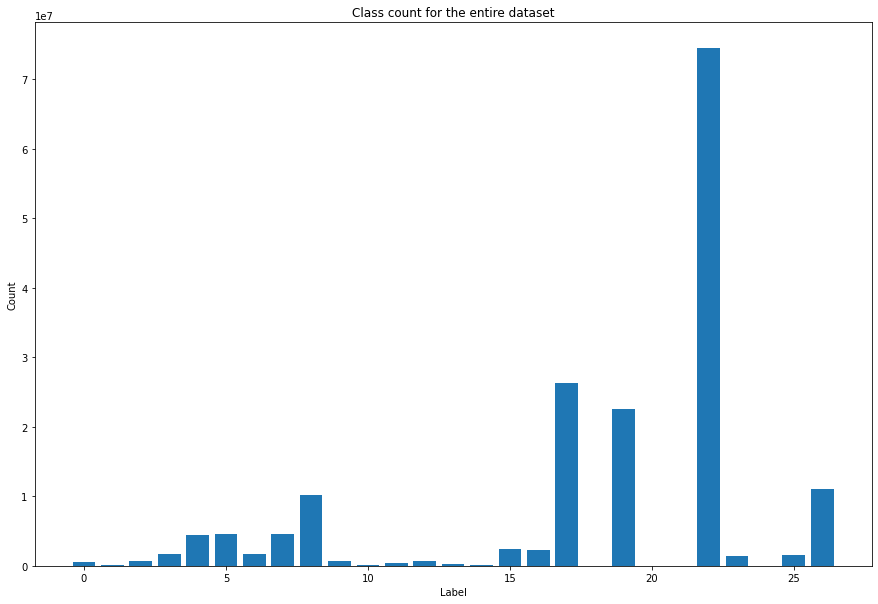

In [119]:
import matplotlib.pyplot as plt

# NB! See classDict.py!

strlist = [{}]*len(n_classes_dataset)
strlist[0] = "Unclassified"
strlist[1] = "Continuous Urban Fabric"
strlist[2] = "Discontinuous Dense Urban Fabric"
strlist[3] = "Discontinuous Medium Density Urban Fabric"
strlist[4] = "Discontinuous Low Density Urban Fabric"
strlist[5] = "Discontinuous Very Low Density Urban Fabric"
strlist[6] = "Isolated Structures"
strlist[7] = "Industrial, commercial, public, military and private units"
strlist[8] = "Roads"
strlist[9] = "Railways and associated land"
strlist[10] = "Port areas"
strlist[11] = "Airports"
strlist[12] = "Mineral extraction and dump sites"
strlist[13] = "Construction sites"
strlist[14] = "Land without current use"
strlist[15] = "Green urban areas"
strlist[16] = "Sports and leisure facilities"
strlist[17] = "Arable land (annual crops)"
strlist[18] = "Permanent crops (vineyards, fruit trees, olive groves)"
strlist[19] = "Pastures"
strlist[20] = "Complex and mixed cultivation patterns"
strlist[21] = "Orchards at the fringe of urban classes"
strlist[22] = "Forests"
strlist[23] = "Herbaceous vegetation associations (natural grassland, moors...)"
strlist[24] = "Open spaces with little or no vegetations (beaches, dunes, bare rocks, glaciers)"
strlist[25] = "Wetland"
strlist[26] = "Water bodies"

print("Class count for the entire dataset:\n")

for i in range(len(n_classes_dataset)):
    print(f'Label {i}: {n_classes_dataset[i].item():,} <<>> <<>> <<>> {strlist[i]}')
    
print("\nClass percentage for the entire dataset:\n")  
for i in range(len(n_classes_dataset)):
    print(f'Label {i}: {n_classes_dataset[i].item()/n_classes_dataset.sum()*100:.3f} % <<>> <<>> <<>> {strlist[i]}') 

print("\nClass weights for the entire dataset\n")
    
for i in range(len(n_classes_dataset)):
    print(f'Label {i}: {class_weights_dataset[i].item():.1f} <<>> <<>> <<>> {strlist[i]}')
 
fig=plt.figure(figsize = (15,10))
plt.bar(range(len(n_classes_dataset)),n_classes_dataset)
plt.title("Class count for the entire dataset")
plt.xlabel("Label")
plt.ylabel("Count")